# Subreddit Biber Entropy

Calculate the linguistic variation for different subreddits using Biber (1988)'s linguistic features

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from scipy.stats import entropy
from glob import glob
import urllib.request, json

from bibermda.tagger import load_config, load_pipeline, tag_text, calculate_tag_frequencies

## Data Setup

**Read in 2019 comment samples from every subreddit**

In [2]:
# df = pd.read_csv('/shared/3/projects/style-influence/data/final_samples/formality_allmetrics.tsv', sep='\t')
df = pd.read_csv('/shared/3/projects/style-influence/data/final_samples/formality_2019.tsv', sep='\t', index_col=0)
df.head()

/tmp/ipykernel_2201252/2343793912.py:2: DtypeWarning: Columns (0,4,5,6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/shared/3/projects/style-influence/data/final_samples/formality_2019.tsv', sep='\t', index_col=0)


,body,author,comment_id,created_utc,controversiality,score,author_flair_css_class,author_flair_text,depth,max_depth,...,parent_author,parent_id,parent_created_utc,parent_controversiality,parent_score,parent_flair_css_class,parent_flair_text,tokens,comment_id_parent,tokens_parent
434,no I used to be but now im buff like matt daemon,tofu_schmo,eq8h3wy,1559865252,0,2,NaN,NaN,11.0,11,...,ruttydm,eq7wnb2,1.559855e+09,0.0,0.0,NaN,NaN,"['no', 'i', 'used', 'to', 'be', 'but', 'now', ...",eq7wnb2,"['amp', 'x200b', 'your', 'cat', 'is', 'fat', '..."
435,&amp;#x200B;\n\nYour cat is fat and you're alm...,ruttydm,eq7wnb2,1559854536,0,0,NaN,NaN,10.0,11,...,tofu_schmo,eq7s9y5,1.559852e+09,0.0,6.0,NaN,NaN,"['amp', 'x200b', 'your', 'cat', 'is', 'fat', '...",eq7s9y5,"['yeah', 'it', 'is', 'super', 'dangerous', 'wh..."
436,yeah it is super dangerous which is y all vega...,tofu_schmo,eq7s9y5,1559850779,0,6,NaN,NaN,8.0,11,...,ruttydm,eq7p0m2,1.559851e+09,0.0,-5.0,NaN,NaN,"['yeah', 'it', 'is', 'super', 'dangerous', 'wh...",eq7p0m2,"['it', 'shows', 'the', 'dangers', 'of', 'being..."
437,It shows the dangers of being vegan.,ruttydm,eq7p0m2,1559850697,0,-5,NaN,NaN,7.0,11,...,tofu_schmo,eq7ovqr,1.559851e+09,0.0,7.0,NaN,NaN,"['it', 'shows', 'the', 'dangers', 'of', 'being...",eq7ovqr,"['no', 'ur', 'video', 'had', 'like', '7', 'peo..."
438,no ur video had like 7 people that didnt look ...,tofu_schmo,eq7ovqr,1559850632,0,7,NaN,NaN,6.0,11,...,ruttydm,eq7mab4,1.559849e+09,0.0,-2.0,NaN,NaN,"['no', 'ur', 'video', 'had', 'like', '7', 'peo...",eq7mab4,"['the', 'level', 'of', 'sarcasm', 'is', 'high']"


**Count comments per subreddit in the sample**

In [10]:
sub_counts = pd.DataFrame(df['subreddit'].value_counts()).reset_index()
sub_counts.columns = ['subreddit', 'count']
sub_counts.head()

,subreddit,count
0,teenagers,120711
1,AskReddit,104250
2,Market76,50761
3,unpopularopinion,39281
4,pokemontrades,38726


**Add in user counts (2019)**

In [11]:
with urllib.request.urlopen("https://pastebin.com/raw/XVBDM4jn") as url:
    data = json.load(url)
    
rows = []
for sub, users in data.items():
    rows.append({
        'subreddit': sub[2:].strip(),
        'users': int(users)
    })
    
sub_users = pd.DataFrame(rows)
sub_counts = sub_counts.merge(sub_users, on='subreddit')
print(len(sub_counts))
sub_users.head()

1057


,subreddit,users
0,gifs,19843047
1,behindthegifs,242978
2,gif,234972
3,Cinemagraphs,1020842
4,WastedGifs,207150


**Pick 500 subreddits stratified by length of the sample size**

**Filter to subs with at least 500 comments in the 2019 sample**

In [12]:
sub_counts['quantile'] = pd.qcut(sub_counts['users'], 4, labels=["1Q", "2Q", "3Q", '4Q'])
sub_counts = sub_counts[sub_counts['count'] >= 250]
sub_counts.head()

,subreddit,count,users,quantile
0,teenagers,120711,1878901,4Q
1,AskReddit,104250,27591007,4Q
2,unpopularopinion,39281,1199297,4Q
3,AMA,16413,528592,3Q
4,relationship_advice,15152,2958208,4Q


In [13]:
sub_counts['quantile'].value_counts()

4Q    150
2Q     86
3Q     77
1Q     72
Name: quantile, dtype: int64

In [14]:
sample_subs = sub_counts.groupby('quantile').sample(n=70, replace=False, random_state=1)['subreddit'].tolist()
len(sample_subs)

280

In [15]:
sample_df = df[['root_id', 'comment_id', 'author', 'subreddit', 'body']]
sample_df = sample_df[sample_df['subreddit'].isin(sample_subs)]
len(sample_df)

354830

**Sample up to 10,000 comments per subreddit. Minimum of 1k comments**

In [16]:
frames = []

for subreddit in tqdm(sample_df['subreddit'].unique()):
    subreddit_df = sample_df[sample_df['subreddit'] == subreddit]
    sample_size = min(10000, len(subreddit_df))
    sub_sample_df = subreddit_df.sample(n=sample_size, replace=False, random_state=0)
    frames.append(sub_sample_df)
    
subreddit_samples = pd.concat(frames, ignore_index=True)
subreddit_samples.head()

100%|███████████████████████████████████████████| 280/280 [00:04<00:00, 65.15it/s]


,root_id,comment_id,author,subreddit,body
0,evcnza3,evcnza3,CrimsonSun-FTW,tumblr,Its awoo time
1,f2tne71,f2y4kwy,boop-oop-a-doop-bop,tumblr,I’m saying this has the potential to backfire ...
2,f2a22se,f2a5phf,65mariokart,tumblr,‘
3,euh53de,euh53de,dirigibalistic,tumblr,Why the Fuck did we stop making these
4,f23qdib,f254rz8,one2z,tumblr,alparlabratories\n\n&gt;is it blood that has a...


**Combine text for users at the subreddit level**

In [17]:
subreddit_samples['body'] = subreddit_samples['body'].astype(str)
subreddit_samples['text'] = subreddit_samples[['author', 'subreddit', 'body']].groupby(['author','subreddit'])['body'].transform(lambda x: ' '.join(x))
subreddit_samples = subreddit_samples[['author','subreddit','text']].drop_duplicates()
subreddit_samples.head()

,author,subreddit,text
0,CrimsonSun-FTW,tumblr,Its awoo time Ever heard of the *communist man...
1,boop-oop-a-doop-bop,tumblr,I’m saying this has the potential to backfire ...
2,65mariokart,tumblr,"‘ O E Y H , N O"
3,dirigibalistic,tumblr,Why the Fuck did we stop making these Hmmm... ...
4,one2z,tumblr,alparlabratories\n\n&gt;is it blood that has a...


In [18]:
len(subreddit_samples)

69655

**Limit to at least 100 words**

In [19]:
filtered_rows = []

for row in tqdm(subreddit_samples.itertuples()):
    words = len(row.text.split(' '))
    if words >= 100:
        filtered_rows.append(row)

subreddit_texts = pd.DataFrame(filtered_rows)
len(subreddit_texts)

69655it [00:00, 135575.39it/s]


31749

**Save for later**

In [20]:
subreddit_texts.to_csv('/shared/3/projects/style-influence/data/samples/2019_subs_text_samples.tsv', sep='\t', index=False)

In [21]:
print(subreddit_texts['text'].apply(len).median(), subreddit_texts['text'].apply(len).mean())

1179.0 1992.4538725629154


## Tag with Biber Tool

**Tag the posts with the biber tool and record average tag frequencies**

In [22]:
config = load_config()
config.update({'token_normalization': 100, 'use_gpu': False, 'function_words': False, 'grieve_clarke': False})
pipeline = load_pipeline(config)
config

{'biber': True,
 'function_words': False,
 'grieve_clarke': False,
 'function_words_list': [],
 'token_normalization': 100,
 'use_gpu': False,
 'show_progress': False,
 'n_processes': 1,
 'processing_size': 10000,
 'return_text': False,
 'drop_last_batch_pct': 0.5}

In [24]:
rows = []
subreddits = subreddit_texts['subreddit'].unique()

for subreddit in tqdm(subreddits):
    texts = subreddit_texts[subreddit_texts['subreddit'] == subreddit]['text']
    for index, text in enumerate(texts):
        try:
            freqs = calculate_tag_frequencies(text, pipeline=pipeline, config=config)
            result = dict(zip(freqs['tag'], freqs['mean']))
            result['index'] = index
            result['subreddit'] = subreddit
            rows.append(result)
        except Exception as e:
            print(subreddit, len(texts))
            print(e)

 71%|██████████████████████████████▌            | 199/280 [26:34<04:42,  3.48s/it]

rugbyunion 53
'tag'


 88%|█████████████████████████████████████▋     | 245/280 [29:14<01:41,  2.90s/it]

terriblefacebookmemes 13
'tag'


100%|███████████████████████████████████████████| 280/280 [31:00<00:00,  6.64s/it]


In [25]:
df = pd.DataFrame(rows)
df.head()

,QUAN,QUPR,AMP,PASS,XX0,JJ,BEMA,CAUS,CONC,COND,...,SPAU,SPIN,THATD,WHOBJ,WHSUB,WHCL,AWL,TTR,index,subreddit
0,1.000000,0.833333,0.166667,0.333333,0.166667,3.666667,1.000000,0.833333,0.000,0.166667,...,0.166667,0.0,1.333333,0.166667,0.500000,0.166667,3.788666,0.758555,0,tumblr
1,1.666667,0.000000,0.000000,0.666667,1.666667,6.500000,1.166667,0.166667,0.000,0.500000,...,0.833333,0.0,0.333333,0.166667,0.166667,0.166667,3.750787,0.734614,1,tumblr
2,0.500000,0.500000,0.000000,0.000000,1.500000,5.000000,0.500000,0.000000,0.000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.500000,0.500000,3.904930,0.811033,2,tumblr
3,0.750000,0.875000,0.000000,0.250000,1.250000,5.375000,2.750000,0.000000,0.125,0.625000,...,0.500000,0.0,0.500000,0.000000,0.125000,0.375000,3.749567,0.711568,3,tumblr
4,0.000000,0.000000,0.000000,0.000000,0.500000,8.500000,1.000000,0.000000,0.000,0.500000,...,0.000000,0.0,0.500000,0.000000,0.500000,0.000000,3.557143,0.735714,4,tumblr


In [26]:
df.to_csv('/shared/3/projects/style-influence/data/entropy/2019_tag_counts.tsv', sep='\t', index=False)

## Entropy Calculations

**Calculate subreddit entropy per tag**

In [27]:
tags = df.columns.tolist()
tags.remove("index")
tags.remove("subreddit")

In [28]:
tag_entropies = []

for tag in tags:
    entropies = df.groupby('subreddit')[tag].apply(lambda x : entropy(x.value_counts(), base=2))
    result = dict(zip(entropies.index.tolist(), entropies.values))
    result['tag'] = tag
    tag_entropies.append(result)
    
entropies_df = pd.DataFrame(tag_entropies)
entropies_df.head()

,3Dprinting,4chan,ADHD,AMA,Anticonsumption,Anxiety,Art,Bad_Cop_No_Donut,BokuNoHeroAcademia,Buddhism,...,whatisthisthing,whatsthisbug,whowouldwin,windows,woooosh,worldnews,youngpeopleyoutube,youtube,yugioh,tag
0,4.154760,3.386266,4.146582,4.107090,3.810081,4.368246,3.300817,3.381109,4.640102,4.419275,...,2.495792,2.412255,5.243044,3.735782,1.925411,4.939582,2.396310,3.799195,4.508117,QUAN
1,3.103397,3.168233,3.229122,3.329449,3.350586,3.791907,2.911851,2.966380,3.694824,3.557875,...,2.176698,2.295587,4.395407,2.203496,2.173973,4.025304,1.911093,3.300713,3.150802,QUPR
2,2.296056,2.422675,2.554824,2.608315,2.865275,2.629755,2.411409,2.289401,3.073483,3.090684,...,1.582235,2.468738,3.689874,2.023491,1.439254,2.980879,0.722858,2.609831,2.489156,AMP
3,2.905207,3.044913,3.236330,2.956026,3.429908,2.772323,2.718408,3.283477,3.879580,4.179194,...,3.084673,2.593848,4.650510,2.642995,1.140068,4.471409,1.663605,3.005365,3.082315,PASS
4,3.870763,3.572624,4.326240,4.320276,4.134336,4.364910,3.490191,4.041365,4.787530,4.597076,...,3.305583,3.215166,5.592610,3.913750,2.866587,5.429450,2.527496,3.950672,4.379924,XX0


In [29]:
entropies_df.to_csv('/shared/3/projects/style-influence/data/entropy/2019_subreddit_tag_entropies.tsv', sep='\t', index=False)

## Visualizing Entropy

**Calculate average and total entropy for the subreddits**

In [30]:
mean_entropies = entropies_df.mean().reset_index()
mean_entropies = mean_entropies.rename({
    'index': 'subreddit',
     0: 'Mean Entropy'
}, axis=1)

sum_entropies = entropies_df.drop('tag', axis=1).sum().reset_index()
sum_entropies = sum_entropies.rename({
    'index': 'subreddit',
     0: 'Sum Entropy'
}, axis=1)

entropies = mean_entropies.merge(sum_entropies, on='subreddit')
entropies = entropies.merge(sub_users, on='subreddit')
entropies.head()

/tmp/ipykernel_2201252/2851289346.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  mean_entropies = entropies_df.mean().reset_index()


,subreddit,Mean Entropy,Sum Entropy,users
0,3Dprinting,3.214517,221.801685,456770
1,4chan,2.598331,179.284818,1145910
2,ADHD,3.289610,226.983107,721919
3,AMA,3.314779,228.719756,528592
4,Anticonsumption,3.117201,215.086842,216158


**Entropy vs Number of Users**

In [41]:
entropies = entropies.rename({'users': 'Total Subscribers'}, axis=1)

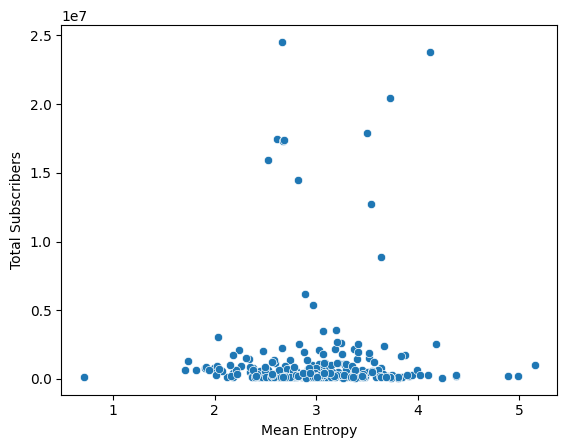

In [47]:
sns.color_palette("colorblind")
plot = sns.scatterplot(data=entropies, x='Mean Entropy', y='Total Subscribers')
fig = plot.get_figure()
fig.savefig("subscribers_vs_entropy.pdf") 

In [43]:
print("Top 10 Subreddits - Linguistic Variation")
entropies.sort_values('Mean Entropy', ascending=False).head(10)

Top 10 Subreddits - Linguistic Variation


,subreddit,Mean Entropy,Sum Entropy,Total Subscribers
91,changemyview,5.153921,355.620516,1002730
11,Christianity,4.989837,344.298729,233924
24,JordanPeterson,4.893304,337.638001,204784
259,ukpolitics,4.380175,302.232086,250356
273,whowouldwin,4.379028,302.152955,300058
10,Catholicism,4.239853,292.549838,91610
65,atheism,4.178679,288.328854,2569757
276,worldnews,4.122466,284.450149,23831500
34,MensRights,4.102351,283.062239,259584
260,unitedkingdom,4.021856,277.508090,291622


In [39]:
print("Bottom 10 Subreddits - Linguistic Variation")
entropies.sort_values('Mean Entropy', ascending=True).head(10)

Bottom 10 Subreddits - Linguistic Variation


,subreddit,Mean Entropy,Sum Entropy,users
216,redditsings,0.710145,49.000000,139600
109,dontputyourdickinthat,1.703868,117.566894,648116
226,shittyfoodporn,1.736773,119.837308,1281692
145,ihadastroke,1.812491,125.061845,622681
45,Shitty_Car_Mods,1.902236,131.254254,764139
275,woooosh,1.916624,132.247029,840221
277,youngpeopleyoutube,1.942859,134.057271,646223
148,imsorryjon,1.993790,137.571540,791199
211,pyrocynical,2.016842,139.162071,294717
235,softwaregore,2.020975,139.447258,930731


In [44]:
entropies[['Mean Entropy', 'Total Subscribers']].corr()

,Mean Entropy,Total Subscribers
Mean Entropy,1.000000,0.049588
Total Subscribers,0.049588,1.000000


<Axes: xlabel='users', ylabel='Mean Entropy'>

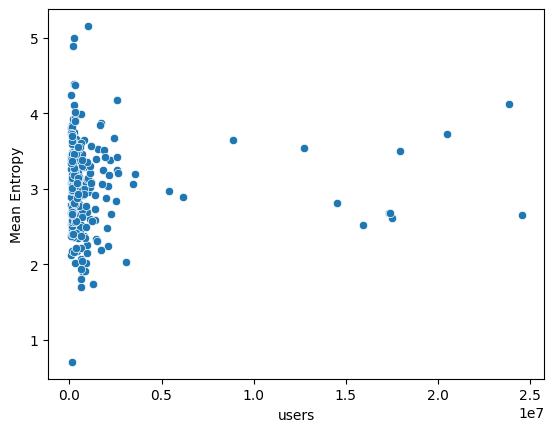

In [33]:
sns.scatterplot(data=entropies, x='users', y='Mean Entropy')